# 作業 : 比較 transformer 和 RNN - attention 效果 以及可視化 transformer 
- 了解 transformer 的效能
- 可視化 transformer 以更了解 transformer 內部結構

# 如果之前的範例程式有跑完訓練 這邊的程式應該可以順利執行
## 請注意後面標註 [作業重點] 之處 並且注意觀察比較程式輸出結果
### 如 [作業重點] 比較 transformer 和 RNN - attention 效果

# [作業目標]
- 比較  transformer 和 RNN - attention 效果
- 可視化 transformer 內部參數

# [作業重點]
- 比較 transformer 和 RNN - attention 效果
-- 模型效果
-- 訓練速度
-- 模型大小
- 可視化 transformer 以更了解 transformer 內部學習結果


In [ ]:
import re
import numpy as np
import spacy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載字體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download
!mv taipei_sans_tc_beta.ttf /usr/local/lib/python3.6/dist-packages/matplotlib//mpl-data/fonts/ttf

from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt 
plt.style.use("seaborn-whitegrid")
import matplotlib.ticker as ticker
# 自定義字體變數
myfont = FontProperties(fname=r'/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/taipei_sans_tc_beta.ttf')

--2020-11-24 07:18:01--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 172.217.7.206, 2607:f8b0:4004:801::200e
Connecting to drive.google.com (drive.google.com)|172.217.7.206|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ob9i031j7qoj8s8h7lgon1auf5kgtae9/1606202250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2020-11-24 07:18:04--  https://doc-0k-9o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ob9i031j7qoj8s8h7lgon1auf5kgtae9/1606202250000/02847987870453524430/*/1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)... 172.217.2.97, 2607:f8b0:4004:80a::2001
Connecting to doc-0k-9o-docs.googleusercontent.com (doc-0k-9o-docs.googleusercontent.com)|172.217.2.97|:443..

In [ ]:
# 設定 torchtext 版本 安裝完必須重新啟動執行階段
!pip install torchtext==0.6.0
from torchtext.data import Field, BucketIterator, TabularDataset

     |████████████████████████████████| 71kB 7.6MB/s 
     |████████████████████████████████| 1.1MB 25.9MB/s 
  Found existing installation: torchtext 0.3.1
    Uninstalling torchtext-0.3.1:
      Successfully uninstalled torchtext-0.3.1


先連接自己的GOOGLE DRIVE 為了要儲存資料和訓練模型

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 使用torchtext TabularDataset 讀資料

## 並且分別讀取訓練時儲存的 src and target 的 字元表
## 如果對torchtext 不太熟習的人可以回去複習一下
## 這邊有用到一個有名的 NLP套件 spacy 幫我們做 英文tokenize

In [ ]:
data_dir = '/content/drive/My Drive/cupoy/transformer/data/'
model_dir =  '/content/drive/My Drive/cupoy/transformer/model/'
# 下載 spacy 的英文模型 幫我們做tokenize
spacy_eng = spacy.load('en_core_web_sm')
def tokenize_eng(text):
  #清除不需要的字符
  text = re.sub(r"([.!?])", r" \1", text)
  return [tok.text for tok in spacy_eng.tokenizer(text)]

TRG = Field(tokenize = tokenize_eng, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)


def tokenize_cmn(text):
  #去掉非中文字元
  regex = re.compile(r'[^\u4e00-\u9fa5A-Za-z0-9]')
  text = regex.sub(' ', text)

  return [word for word in text if word.strip()]
    

SRC = Field(tokenize = tokenize_cmn, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

train_dataset, dev_dataset, test_dataset = TabularDataset.splits(
    path = data_dir , format = 'csv', skip_header = True,
    train='train.csv', validation='val.csv', test='test.csv',
    fields=[
        ('trg', TRG),
        ('src', SRC)
    ]
)


# 讀取之前儲存的 vocabulary
SRC.vocab = torch.load(model_dir + 'SRC_vocab.pt')
TRG.vocab = torch.load(model_dir + 'TRG_vocab.pt')


print ("中文語料的字元表長度: " , len(SRC.vocab) , ", 英文的字元表長度: " ,len(TRG.vocab))
print ("Sample SRC:", test_dataset[0].src , "TRG:", test_dataset[0].trg)

BATCH_SIZE = 128

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

valid_iterator, test_iterator = BucketIterator.splits(
    (dev_dataset, test_dataset), 
     batch_size = BATCH_SIZE,
     sort_within_batch = True,
     sort_key = lambda x : len(x.src),
     device = device)

中文語料的字元表長度:  2706 , 英文的字元表長度:  4051
Sample SRC: ['你', '有', '除', '锈', '的', '东', '西', '吗'] TRG: ['do', 'you', 'have', 'anything', 'to', 'remove', 'stains', '?']


# Transformer 本體
## 和之前版本完全相同 只是去除 comments
## 簡單版本 共 172 行

In [ ]:
class TransformerEncoder(nn.Module):
  """ Transformer 的 encoder """
  def __init__(self, hidden_dim, feedforward_dim, n_enc_layers, n_attn_heads, dropout, src_voca_length, max_pos_length , device):
      super().__init__()
      self.device = device
      self.src_tok_embedding = nn.Embedding(src_voca_length , hidden_dim ) 
      self.src_pos_embedding = nn.Embedding(max_pos_length, hidden_dim) 
      self.transformer_encoder_layers = nn.ModuleList([TransformerEncoderLayer(hidden_dim, 
                                            feedforward_dim,
                                            n_enc_layers,
                                            n_attn_heads, 
                                            dropout, 
                                            device) for _ in range(n_enc_layers)])
      self.dropout = nn.Dropout(dropout)

  def forward(self, src_sentence, src_mask):
        batch_size = src_sentence.shape[0]
        src_len = src_sentence.shape[1]
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        src_sentence = self.dropout(self.src_tok_embedding(src_sentence)  + self.src_pos_embedding(pos))
        for layer in self.transformer_encoder_layers:
            src_sentence , encoder_self_attention = layer(src_sentence, src_mask)
        return src_sentence , encoder_self_attention

class TransformerEncoderLayer(nn.Module):
  def __init__(self, hidden_dim , feedforward_dim, n_enc_layers, n_attn_heads, dropout , device):
    super().__init__()
    self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim,n_attn_heads,dropout,device)
    self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
    self.feedforward_sublayer = PosFeedForwardSubLayer(hidden_dim,feedforward_dim,dropout)
    self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)
  
  def forward(self, src_embedding, src_mask):
    _src,  encoder_self_attention = self.self_attention_sublayer(src_embedding, src_embedding, src_embedding, src_mask)
    src_embedding = self.self_attn_layernorm(src_embedding + self.dropout(_src))
    _src = self.feedforward_sublayer(src_embedding)
    src_embedding = self.feedforward_layernorm(src_embedding + self.dropout(_src))
    return src_embedding , encoder_self_attention

class MultiHeadAttentionSubLayer(nn.Module):
  def __init__(self, hidden_dim , n_attn_heads, dropout, device):
    super().__init__()
    assert hidden_dim % n_attn_heads ==0
    self.hidden_dim = hidden_dim
    self.n_attn_heads = n_attn_heads
    self.head_dim = hidden_dim // n_attn_heads
    self.full_conn_q = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_k = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_v = nn.Linear(hidden_dim, hidden_dim)
    self.full_conn_o = nn.Linear(hidden_dim, hidden_dim)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

  def forward(self, query_input, key_input, value_input, mask = None):
    batch_size = query_input.shape[0]
    Q = self.full_conn_q(query_input)
    K = self.full_conn_k(key_input)
    V = self.full_conn_v(value_input)
    def split_attention(Q, K, V):
      Q = Q.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      K = K.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      V = V.view(batch_size, -1, self.n_attn_heads, self.head_dim)
      return Q , K , V

    def seperate_heads(Q, K, V):
      Q = Q.permute(0, 2, 1, 3) # (batch_size, self.n_heads , query len , self.head_dim)
      K = K.permute(0, 2, 1, 3) # (batch_size, self.n_heads , key len , self.head_dim)
      V = V.permute(0, 2, 1, 3) # (batch_size, self.n_heads , value len , self.head_dim)
      return Q , K , V

    Q, K, V = split_attention(Q, K, V)
    Q, K, V = seperate_heads (Q, K, V)
    scaled_dot_product_similarity = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
    if mask is not None:
      scaled_dot_product_similarity = scaled_dot_product_similarity.masked_fill(mask == 0, -1e10)
    attention = torch.softmax(scaled_dot_product_similarity, dim = -1)
    x = torch.matmul(self.dropout(attention), V)
    x = x.permute(0, 2, 1, 3).contiguous()   
    x = x.view(batch_size, -1, self.hidden_dim)    
    x = self.full_conn_o(x)
    return x, attention

class PosFeedForwardSubLayer(nn.Module):
  def __init__(self, hidden_dim, ff_dim, dropout):
    super().__init__()
    self.full_conn_1 = nn.Linear(hidden_dim, ff_dim)
    self.full_conn_2 = nn.Linear(ff_dim,  hidden_dim)
    self.dropout = nn.Dropout(dropout)
    
  def forward(self, x):
    x = self.dropout(torch.relu(self.full_conn_1(x)))
    x = self.full_conn_2(x)
    return x

class TransformerDecoder(nn.Module):
  def __init__(self, hidden_dim, feedforward_dim, n_dec_layers, n_attn_heads, dropout, dec_voca_length, max_pos_length , device , skip_encoder_attn = False):
    super().__init__()
    self.device = device
    self.dec_tok_embedding = nn.Embedding(dec_voca_length, hidden_dim )
    self.dec_pos_embedding = nn.Embedding(max_pos_length, hidden_dim)
    self.transformer_decoder_layers = nn.ModuleList([TransformerDecoderLayer(hidden_dim,
                                          feedforward_dim, 
                                          n_dec_layers,
                                          n_attn_heads,
                                          dropout, 
                                          device, skip_encoder_attn) for _ in range(n_dec_layers)])
    self.full_conn_out = nn.Linear(hidden_dim, dec_voca_length)
    self.dropout = nn.Dropout(dropout)
    self.scale = torch.sqrt(torch.FloatTensor([hidden_dim])).to(device)

  def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):       
    batch_size = dec_seq.shape[0]
    dec_len = dec_seq.shape[1]
    pos = torch.arange(0, dec_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)                        
    dec_seq = self.dropout(self.dec_tok_embedding(dec_seq)  + self.dec_pos_embedding(pos))
    for layer in self.transformer_decoder_layers:
      dec_seq, encoder_decoder_attention , decoder_self_attention = layer(dec_seq, enc_hidden, dec_mask, enc_mask)   
    output = self.full_conn_out(dec_seq)      
    return output, encoder_decoder_attention , decoder_self_attention

class TransformerDecoderLayer(nn.Module):
  def __init__(self, hidden_dim , feedforward_dim, n_dec_layers, n_attn_heads, dropout , device , skip_encoder_attn = False):
    super().__init__()
    self.skip_encoder_attn = skip_encoder_attn 
    self.self_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
    self.self_attn_layernorm = nn.LayerNorm(hidden_dim)
    if not skip_encoder_attn:
      self.encoder_attention_sublayer = MultiHeadAttentionSubLayer(hidden_dim, n_attn_heads, dropout, device)
      self.encoder_attn_layernorm = nn.LayerNorm(hidden_dim)
    self.positionwise_feedforward = PosFeedForwardSubLayer(hidden_dim,feedforward_dim ,dropout)
    self.feedforward_layernorm = nn.LayerNorm(hidden_dim)
    self.dropout = nn.Dropout(dropout)     

  def forward(self, dec_seq, enc_hidden , dec_mask, enc_mask):
    _dec_seq, decoder_self_attention = self.self_attention_sublayer(dec_seq, dec_seq, dec_seq, dec_mask)
    dec_seq = self.self_attn_layernorm(dec_seq + self.dropout(_dec_seq))      
    if not self.skip_encoder_attn:
      _dec_seq, encoder_decoder_attention = self.encoder_attention_sublayer(dec_seq, enc_hidden, enc_hidden, enc_mask)
      dec_seq = self.encoder_attn_layernorm(dec_seq + self.dropout(_dec_seq))
    else:
      encoder_decoder_attention = None
    _dec_seq = self.positionwise_feedforward(dec_seq)
    dec_seq = self.feedforward_layernorm(dec_seq + self.dropout(_dec_seq))
    return dec_seq, encoder_decoder_attention , decoder_self_attention
        
class Transformer(nn.Module):
  def __init__(self,encoder, decoder, src_pad_idx, trg_pad_idx, device):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_pad_idx = src_pad_idx
    self.trg_pad_idx = trg_pad_idx
    self.device = device

  def make_src_mask(self, src):
    src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
    return src_mask

  def make_trg_mask(self, trg):
    trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
    trg_len = trg.shape[1]    
    trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
    trg_mask = trg_pad_mask & trg_sub_mask
    return trg_mask

  def forward(self, src, trg):
    src_mask = self.make_src_mask(src)
    trg_mask = self.make_trg_mask(trg)
    enc_src , encoder_self_attention = self.encoder(src, src_mask)
    output, encoder_decoder_attention , decoder_self_attention = self.decoder(trg, enc_src, trg_mask, src_mask)
    return output, encoder_decoder_attention , encoder_self_attention ,  decoder_self_attention

# 實際建立模型
- 設定重要參數 要和之前訓練時一樣
-- SRC.vocab 中文 vocab , TRG.vocab 英文 vocab
-- 建立一個 hidden embedding 256，三層encoder layer, 三層decoder layer，各八個attention heads
-- position wise feedforward 中間層 512 dropout 0.1 learning rate: 0.0005
-- 最長句長 40


In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
MAX_SENT_LENGTH = 40
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_FF_DIM = 512
DEC_FF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1
LEARNING_RATE = 0.0005

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]


enc = TransformerEncoder(HID_DIM, ENC_FF_DIM, ENC_LAYERS, ENC_HEADS, ENC_DROPOUT,INPUT_DIM,  MAX_SENT_LENGTH,device)

dec = TransformerDecoder(HID_DIM, DEC_FF_DIM,
              DEC_LAYERS, 
              DEC_HEADS,  
              DEC_DROPOUT, 
              OUTPUT_DIM, MAX_SENT_LENGTH,
              device)

model = Transformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);

print ("Total model parameters {:0.0f}".format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# Evaluation function , 為了觀察我們讀入的模型是否正確

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ , _ , _= model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

# 讀取之前訓練儲存最佳模型
## 求取testing set loss 以確定讀取正確

In [ ]:
model_dir =  '/content/drive/My Drive/cupoy/transformer/model/'
model.load_state_dict(torch.load(model_dir + 'best-model.pt'))
#model.load_state_dict(torch.load(model_dir + 'model-8.pt'))
test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} |')

# 使用訓練的模型 進行中翻英工作

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src , encoder_self_attention = model.encoder(src_tensor, src_mask)

    # 翻譯結果句 先以 init token 開頭
    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, encoder_decoder_attention , decoder_self_attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        # 取得模型最佳預測
        pred_token = output.argmax(2)[:,-1].item()
        # 放入翻譯結果句 
        trg_indexes.append(pred_token)
        # 碰到 eos 結束 
        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], encoder_decoder_attention , encoder_self_attention , decoder_self_attention

# Apply BLEU score
## 必須要設定 torchtext 0.6.0 版本 安裝完必須重新啟動執行階段


In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        #translation, attention = translate_sentence(src, SRC, TRG, model, device)

        pred_trg, _ ,_ ,_= translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

bleu_score = calculate_bleu(test_dataset, SRC, TRG, model, device)

print(f'BLEU score of test dataset = {bleu_score*100:.2f}')

# [作業重點] 比較 transformer 和 RNN - attention 效果
## 請蒐集以下資料
### 模型效果 
#### BLEU
#### Testing Loss
### 訓練速度 
#### 請看 範例程式訓練階段
### 模型大小
## 請和 RNN attention 比較



# 這邊是展示transformer attention layer 的權重函式
## plot_attention --> 畫出每個attention head 分別的 attention 權重
## plot_attention_summary --> 畫出 summary attention 權重

In [ ]:
def plot_attention(sentence1 , sentence2, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    fig = plt.figure(figsize=(15,25))
    for i in range(n_heads):    
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()
        cax = ax.matshow(_attention, cmap='bone')
        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+sentence1, 
                           rotation=45,fontproperties=myfont)
        ax.set_yticklabels(['']+sentence2,fontproperties=myfont)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

def plot_attention_summary(sentence1, sentence2, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    
    attn_summary = np.sum(attention.squeeze(0).cpu().detach().numpy()  , axis=0)
    cax = ax.matshow(attn_summary, cmap='bone')
    
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+sentence1, 
                       rotation=45 , fontproperties=myfont) #, fontdict=fontdict)
    ax.set_yticklabels(['']+sentence2, fontproperties=myfont) # , fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()


# 選取training set 的資料
## 觀察 翻譯結果 
## 請調整 sample_index 選擇一個翻譯結果比較好的，比較好觀察模型

In [ ]:
sample_index = 1250
src = vars(train_dataset.examples[sample_index])['src']
trg = vars(train_dataset.examples[sample_index])['trg']

print('src = ' , src)
print('trg = ' , trg)

translation, encoder_decoder_attention , encoder_self_attention , decoder_self_attention = translate_sentence(src, SRC, TRG, model, device)

print('翻譯  = ' ,translation)

# [作業重點] 繪製 encoder and decoder attention 
## encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
## Summary 是把 8 個 attention head 的結果累加
## 這邊的結果可以和 RNN-attention 的結果來對比
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察




我已經讀完了這本書 torch.Size([1, 8, 8, 11])


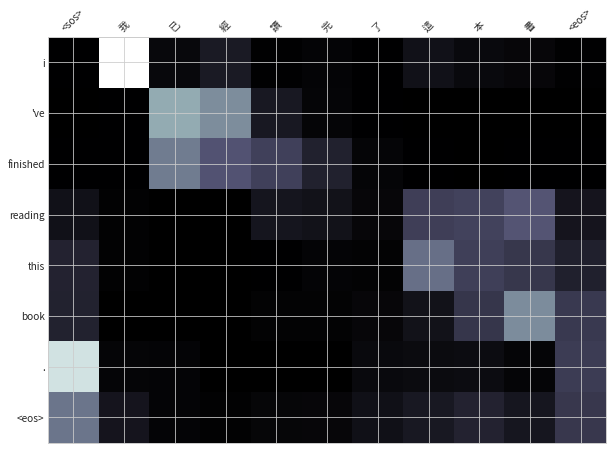

In [ ]:
print ("".join(src ) , encoder_decoder_attention.shape)

plot_attention_summary(['<sos>']+src+['<eos>']  , translation , encoder_decoder_attention)

# [作業重點] 繪製 encoder and decoder attention 
## encoder_decoder_attention 是 transformer decoder 最後一層的attention 值
## 把八個 attention 分開繪製
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察

In [ ]:

plot_attention(['<sos>']+src+['<eos>']  , translation , encoder_decoder_attention)

# [作業重點] 繪製 encoder self attention 
## encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
## Summary 是把 8 個 attention head 的結果累加
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察

In [ ]:
print ("".join(src ) , encoder_self_attention.shape)

plot_attention_summary(['SOS'] + src + ['EOS'] , ['SOS'] + src + ['EOS'] ,  encoder_self_attention)

# [作業重點] 繪製 encoder self attention 
## encoder_self_attention 是 transformer encoder 最後一層的 self attention 值
## 把八個 attention 分開繪製
## 來原句前後要加 sos and eos
## 請將你的觀察寫在這邊:
## 觀察

In [ ]:
plot_attention(['sos'] + src + ['eos'] , ['sos'] + src + ['eos'] , encoder_self_attention)

# [作業重點] 繪製 decoder self attention 
## decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
## Summary 是把 8 個 attention head 的結果累加
## 被attention 的翻譯句 前要加 sos
## 請將你的觀察寫在這邊:
## 觀察

In [ ]:
print ("".join(src ), decoder_self_attention.shape)

plot_attention_summary(['SOS'] + translation  , translation ,  decoder_self_attention)


# [作業重點] 繪製 decoder self attention 
## decoder_self_attention 是 transformer decoder 最後一層的 self attention 值
## 把八個 attention heads 分開繪製
## 被attention 的翻譯句 前要加 sos
## 請將你的觀察寫在這邊:
## 觀察

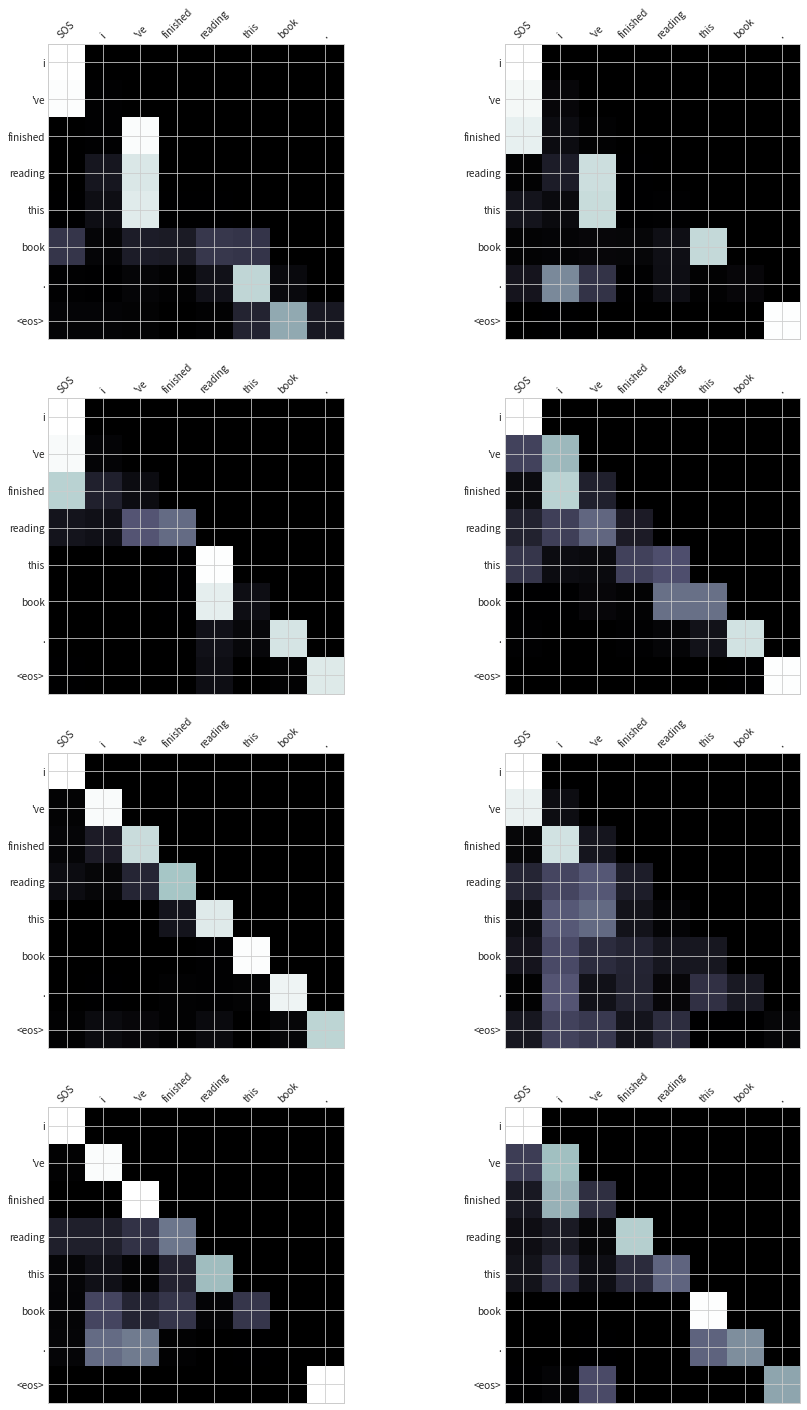

In [ ]:

plot_attention(['SOS'] + translation , translation, decoder_self_attention)